# Fraud Detection Analysis

* Sandikha Rahardi (Kuldii Project)
* https://kuldiiproject.com

This notebook analyzes and builds a fraud detection system using the PaySim dataset. We will perform data loading, exploratory data analysis (EDA), handle class imbalance, preprocess data, train multiple models, evaluate them, and finally build an interactive Gradio interface for fraud prediction.

**Dataset:** [PaySim Kaggle](https://www.kaggle.com/datasets/ealaxi/paysim1)

---

## 1. Load Data

In this section, we will load the PaySim dataset, inspect its structure, check for missing values, and display sample rows.

In [1]:
# %pip install -r requirements.txt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import json
import shutil
import joblib
import zipfile
import subprocess

import numpy as np
import gradio as gr
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from kaggle.api.kaggle_api_extended import KaggleApi
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

In [5]:
csv_file = 'PS_20174392719_1491204439457_log.csv'
kaggle_dataset = 'ealaxi/paysim1'
zip_file = 'paysim1.zip'

if not os.path.exists(csv_file):
    # Install kaggle if needed
    try:
        import kaggle
    except ImportError:
        !{sys.executable} -m pip install kaggle
    # Set up Kaggle API credentials
    kaggle_json_path = os.path.expanduser('~/.kaggle/kaggle.json')
    if not os.path.exists(kaggle_json_path):
        shutil.copy('kaggle.json', kaggle_json_path)
    os.chmod(kaggle_json_path, 0o600)
    # Download dataset
    !kaggle datasets download -d {kaggle_dataset} --unzip -p datasets/
    print(f"Extracted {csv_file}")
else:
    print(f"{csv_file} already exists.")

Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
 92%|████████████████████████████████████▉   | 164M/178M [00:00<00:00, 1.72GB/s]
100%|████████████████████████████████████████| 178M/178M [00:00<00:00, 1.75GB/s]
Extracted PS_20174392719_1491204439457_log.csv


In [6]:
# Read the CSV file into a DataFrame
df = pd.read_csv('datasets/PS_20174392719_1491204439457_log.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
# Check for missing values
print('Missing values per column:')
df.isnull().sum()

Missing values per column:


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

---

## 2. Exploratory Data Analysis (EDA)

We will explore the data with visualizations to understand transaction types, amount distributions, fraud patterns, correlations, and more.

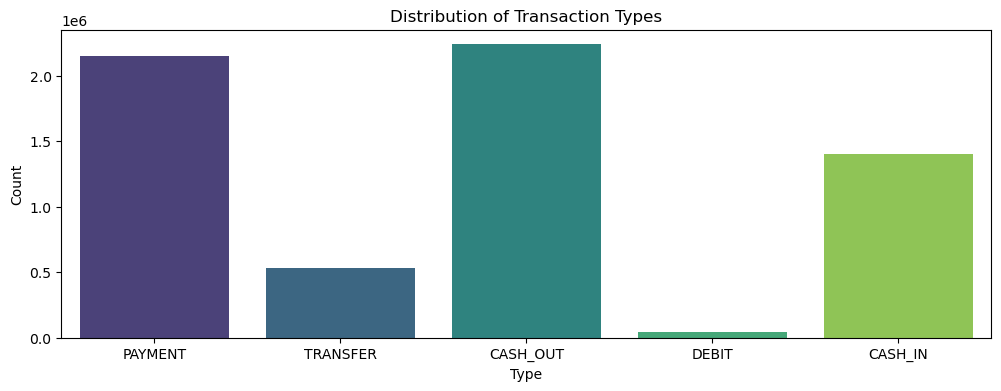

In [12]:
# Plot distribution of transaction types
plt.figure(figsize=(12,4))
sns.countplot(x='type', data=df, palette='viridis')
plt.title('Distribution of Transaction Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()


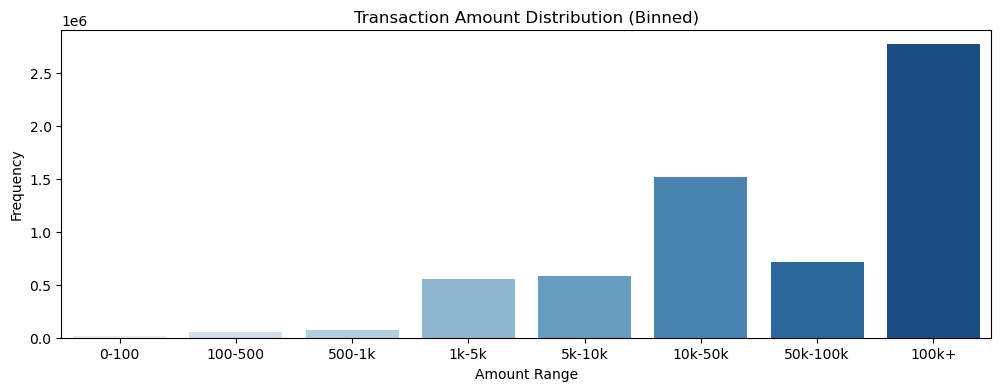

In [23]:
# Plot distribution of transaction amounts with bar (binned)
bins = [0, 100, 500, 1000, 5000, 10000, 50000, 100000, df['amount'].quantile(0.99)]
labels = ['0-100', '100-500', '500-1k', '1k-5k', '5k-10k', '10k-50k', '50k-100k', '100k+']
df['amount_bin'] = pd.cut(df['amount'], bins=bins, labels=labels, include_lowest=True, right=False)
plt.figure(figsize=(12,4))
sns.barplot(x=df['amount_bin'].value_counts().index, y=df['amount_bin'].value_counts().values, palette='Blues')
plt.title('Transaction Amount Distribution (Binned)')
plt.xlabel('Amount Range')
plt.ylabel('Frequency')
plt.show()
df.drop('amount_bin', axis=1, inplace=True)

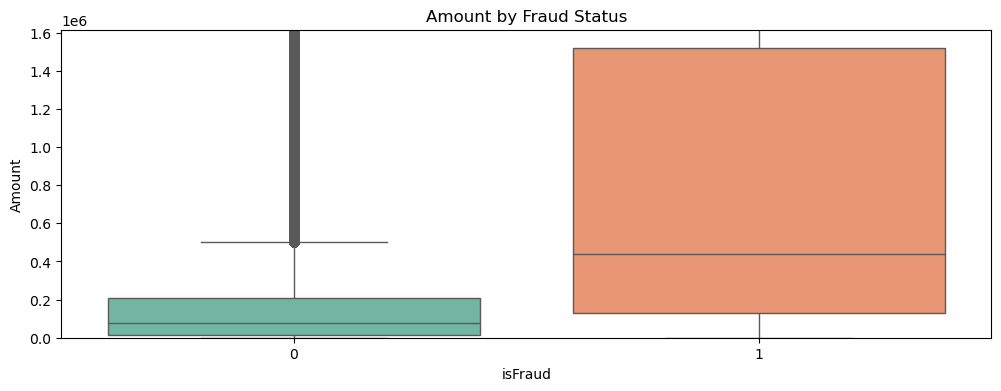

In [18]:
# Boxplot of amount vs isFraud
plt.figure(figsize=(12,4))
sns.boxplot(x='isFraud', y='amount', data=df, palette='Set2')
plt.title('Amount by Fraud Status')
plt.xlabel('isFraud')
plt.ylabel('Amount')
plt.ylim(0, df['amount'].quantile(0.99))
plt.show()

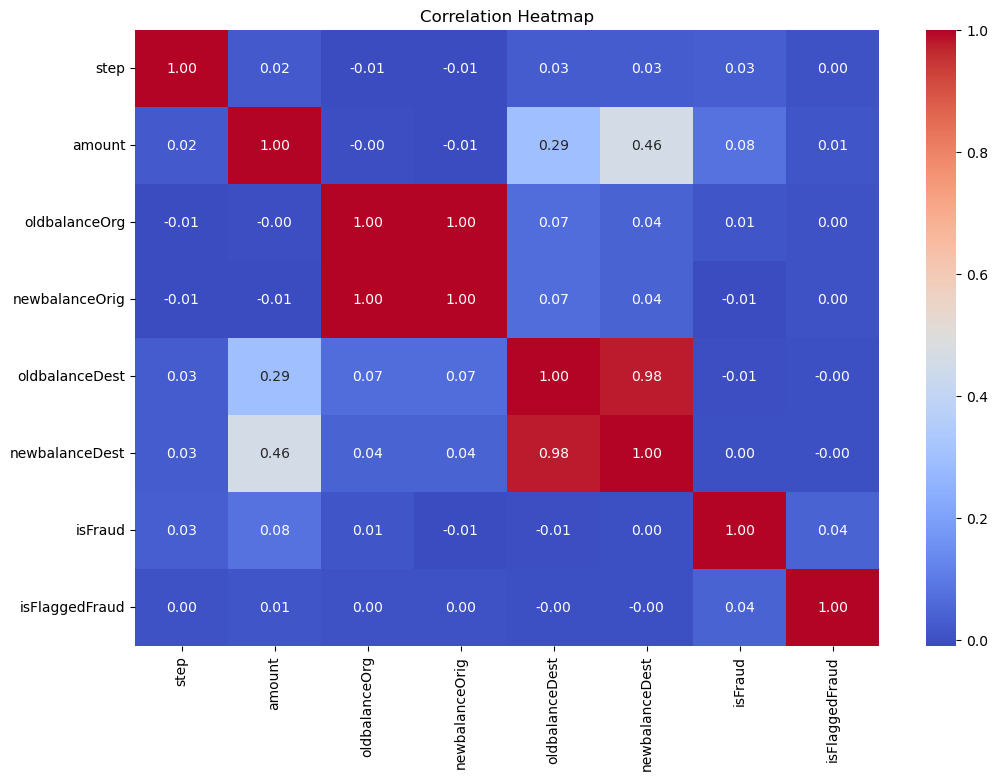

In [20]:
# Correlation heatmap (only numeric columns)
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

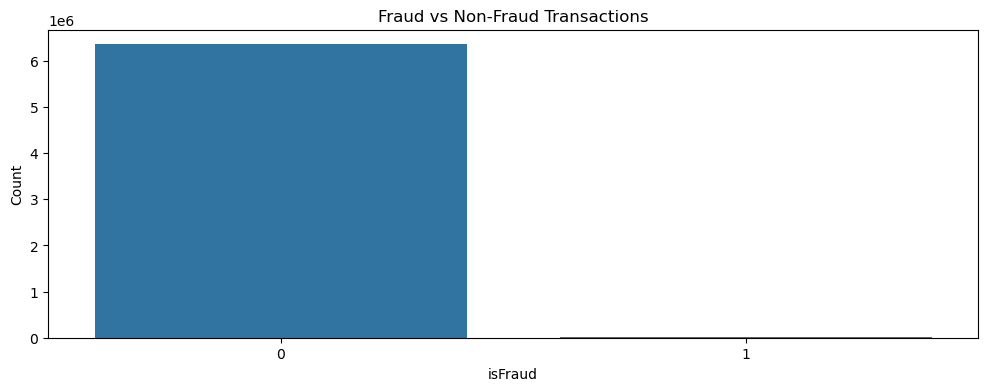

In [21]:
# Count of fraud vs non-fraud transactions
plt.figure(figsize=(12, 4))
sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Transactions')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.show()

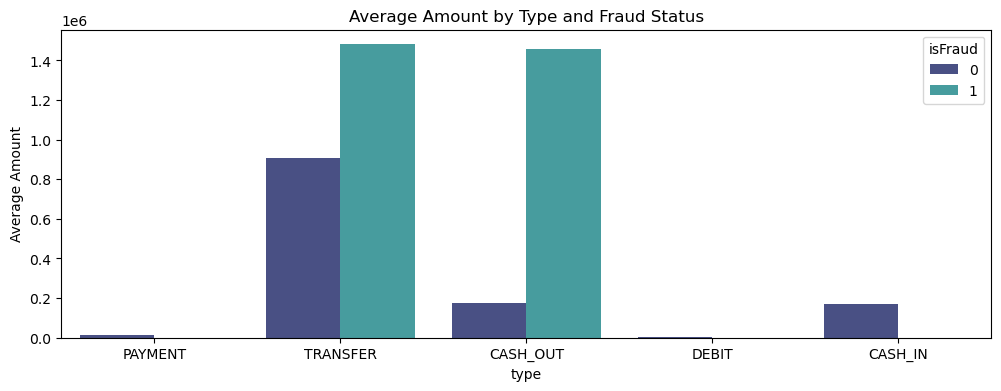

In [22]:
# Additional insight: Average amount by transaction type and fraud status
plt.figure(figsize=(12, 4))
sns.barplot(x='type', y='amount', hue='isFraud', data=df, ci=None, palette='mako')
plt.title('Average Amount by Type and Fraud Status')
plt.ylabel('Average Amount')
plt.show()

---

## 3. Class Imbalance Handling

Fraud detection datasets are often highly imbalanced. Here, we will check the class distribution for `isFraud` and apply techniques like RandomUnderSampler and SMOTE to balance the classes.

Class distribution before balancing:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


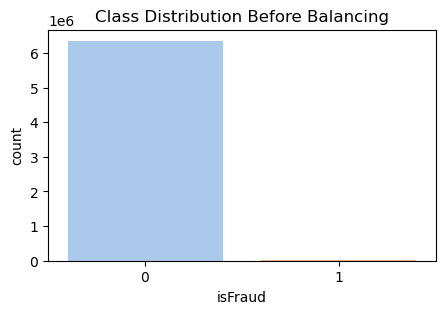

In [24]:
# Check class distribution before balancing
class_counts = df['isFraud'].value_counts()
print('Class distribution before balancing:')
print(class_counts)

plt.figure(figsize=(5,3))
sns.countplot(x='isFraud', data=df, palette='pastel')
plt.title('Class Distribution Before Balancing')
plt.show()

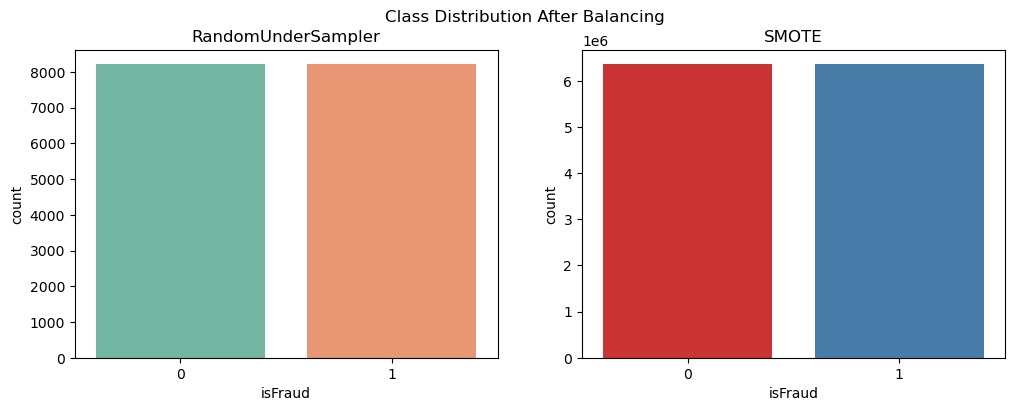

In [26]:
# Prepare features and target for resampling
X = df.drop(['isFraud'], axis=1).copy()
y = df['isFraud']

# Drop object-type columns not useful for modeling
drop_cols = ['nameOrig', 'nameDest']
X_resample = X.drop(columns=drop_cols)

# Encode categorical variables
if 'type' in X_resample.columns:
    X_resample['type'] = X_resample['type'].astype('category').cat.codes

# RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_resample, y)

# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_resample, y)

# Plot class distributions after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=y_rus, ax=axes[0], palette='Set2')
axes[0].set_title('RandomUnderSampler')
sns.countplot(x=y_smote, ax=axes[1], palette='Set1')
axes[1].set_title('SMOTE')
plt.suptitle('Class Distribution After Balancing')
plt.show()

---

## 4. Data Preprocessing

We will encode categorical variables, drop irrelevant columns, and scale features to prepare the data for model training.

In [32]:
def preprocess_data(df, drop_cols=None, scaler=None, le=None):
    df_prep = df.copy()

    # Encode 'type' categorical variable
    if 'type' in df_prep.columns:
        if le is None:
            le = LabelEncoder()
            df_prep['type'] = le.fit_transform(df_prep['type'])
        else:
            df_prep['type'] = le.transform(df_prep['type'])

    # Drop irrelevant columns
    if drop_cols:
        df_prep = df_prep.drop(drop_cols, axis=1)

    # Separate features and target
    features = df_prep.drop('isFraud', axis=1)

    # Scale features
    if scaler is None:
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
    else:
        features_scaled = scaler.transform(features)

    df_scaled = pd.DataFrame(features_scaled, columns=features.columns)
    df_scaled['isFraud'] = df_prep['isFraud'].values

    return df_scaled, scaler, le


# --- Prepare dataframe from RandomUnderSampling ---
# Combine X_rus and y_rus into one dataframe
df_rus = X_rus.copy()
df_rus["isFraud"] = y_rus

# Drop columns if they exist
drop_columns = []
if set(['isFlaggedFraud']).issubset(df_rus.columns):
    drop_columns = ['isFlaggedFraud']

# Preprocess
df_processed, scaler, le = preprocess_data(df_rus, drop_cols=drop_columns)

# Result
df_processed


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,-0.747180,-0.738354,-0.344190,-0.376126,-0.209900,-0.128761,-0.179688,0
1,-0.876502,0.613354,-0.442597,-0.382087,-0.209900,-0.238564,-0.326242,0
2,-0.659241,0.613354,-0.441009,-0.375984,-0.203363,-0.238564,-0.326242,0
3,0.251187,0.613354,-0.441956,-0.380313,-0.208282,-0.238564,-0.326242,0
4,0.246014,-1.414208,-0.306969,0.026335,0.421504,0.540166,0.310322,0
...,...,...,...,...,...,...,...,...
16421,2.258267,-0.738354,-0.260499,-0.277658,-0.209900,-0.238564,-0.238347,1
16422,2.258267,1.289208,2.945770,1.558236,-0.209900,-0.238564,-0.326242,1
16423,2.258267,-0.738354,2.945770,1.558236,-0.209900,-0.218907,1.324596,1
16424,2.258267,1.289208,0.013496,-0.120770,-0.209900,-0.238564,-0.326242,1


---

## 5. Model Training

We will split the data into train and test sets, train Logistic Regression, Random Forest, and XGBoost models, and evaluate them using various metrics and visualizations.

In [33]:
# Prepare features and target
X = df_processed.drop('isFraud', axis=1)
y = df_processed['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

results = {}
models = {}

In [34]:
# Logistic Regression
lr_pipe = Pipeline([
    ('clf', LogisticRegression(max_iter=1000))
])

lr_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['liblinear', 'lbfgs']
}

lr_grid = GridSearchCV(lr_pipe, lr_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
lr_grid.fit(X_train, y_train)
lr_best = lr_grid.best_estimator_
models['Logistic Regression'] = lr_best

In [35]:
# Random Forest
rf_pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
models['Random Forest'] = rf_best

In [37]:
xgb_pipe = Pipeline([
    ('clf', XGBClassifier(eval_metric='logloss', random_state=42))
])

xgb_param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6, 10],
    'clf__learning_rate': [0.01, 0.1, 0.2]
}

xgb_grid = GridSearchCV(
    xgb_pipe,
    xgb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
models['XGBoost'] = xgb_best

Fitting 5 folds for each of 18 candidates, totalling 90 fits



Model: Logistic Regression
Accuracy: 0.9059646987218503
Precision: 0.9638386648122392
Recall: 0.8435788192331102
F1-Score: 0.8997078870496592
ROC AUC: 0.9690951746078551

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1643
           1       0.96      0.84      0.90      1643

    accuracy                           0.91      3286
   macro avg       0.91      0.91      0.91      3286
weighted avg       0.91      0.91      0.91      3286



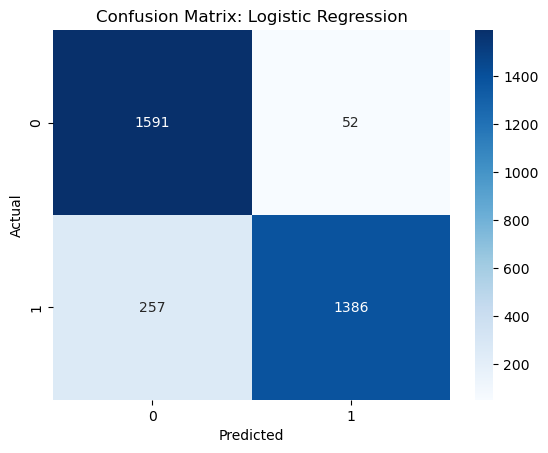

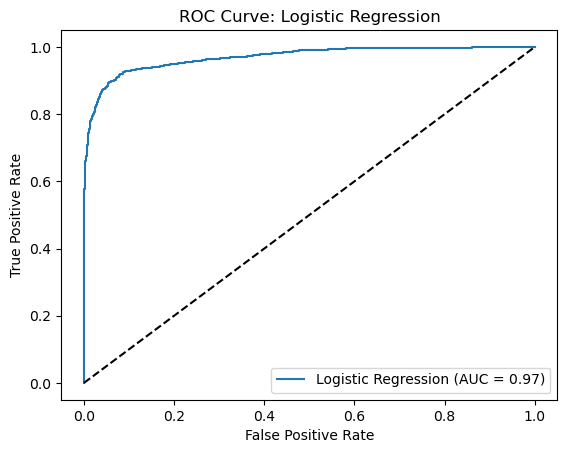


Model: Random Forest
Accuracy: 0.9939135727328059
Precision: 0.9891500904159132
Recall: 0.9987827145465612
F1-Score: 0.9939430648092066
ROC AUC: 0.9995302745115762

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1643
           1       0.99      1.00      0.99      1643

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



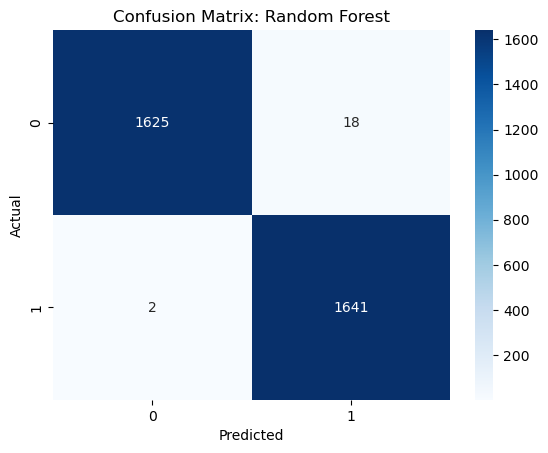

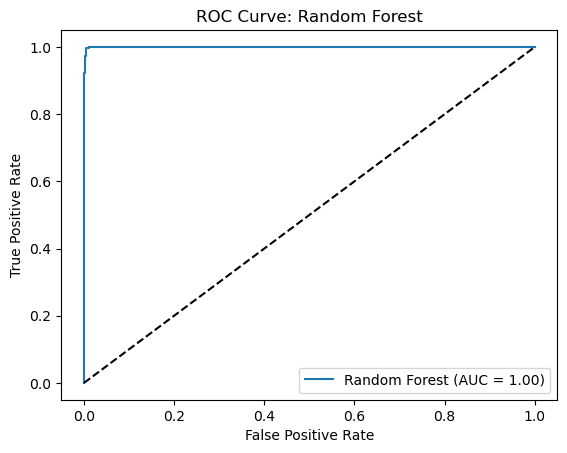


Model: XGBoost
Accuracy: 0.994826536822885
Precision: 0.9927272727272727
Recall: 0.996956786366403
F1-Score: 0.9948375341633768
ROC AUC: 0.9995839891770507

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1643
           1       0.99      1.00      0.99      1643

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



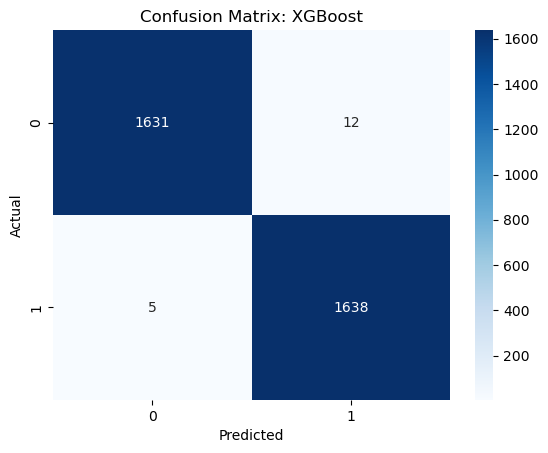

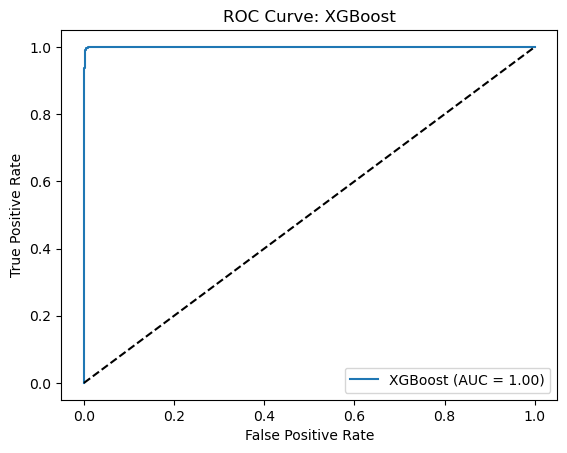

In [38]:
# Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    print(f'\nModel: {model_name}')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1-Score:', f1_score(y_test, y_pred))
    print('ROC AUC:', roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A')
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    # ROC curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc(fpr, tpr):.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve: {model_name}')
        plt.legend()
        plt.show()

# Evaluate all models
for name, model in models.items():
    evaluate_model(model, X_test, y_test, name)
    results[name] = model

---

## 6. Feature Importance

We will visualize feature importance for tree-based models (Random Forest and XGBoost) to understand which features contribute most to fraud detection.

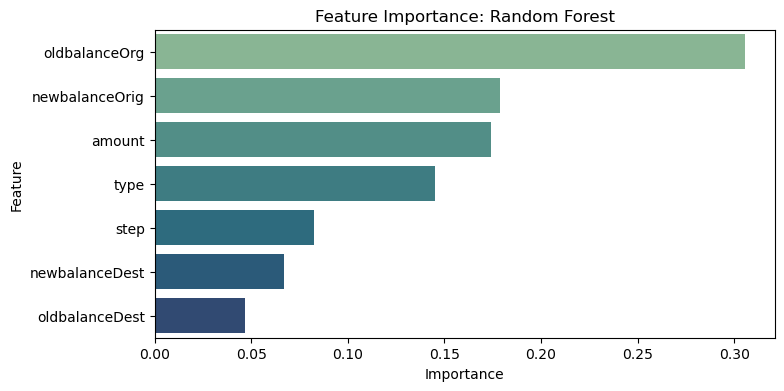

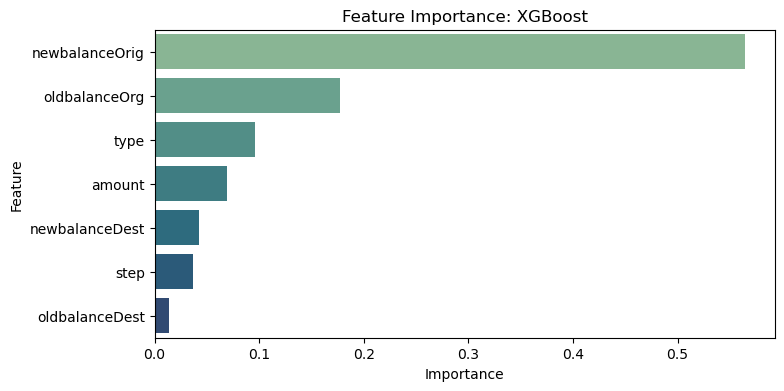

In [39]:
# 7. Feature Importance
def plot_feature_importance(model, feature_names, model_name):
    if hasattr(model.named_steps['clf'], 'feature_importances_'):
        importances = model.named_steps['clf'].feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8,4))
        sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='crest')
        plt.title(f'Feature Importance: {model_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()
    else:
        print(f'No feature_importances_ attribute for {model_name}')

feature_names = X.columns
plot_feature_importance(models['Random Forest'], feature_names, 'Random Forest')
plot_feature_importance(models['XGBoost'], feature_names, 'XGBoost')

In [47]:
# Filter rows where isFlaggedFraud == 1
X_rus[X_rus['isFlaggedFraud'] == 1]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
2736446,212,4,4953893.08,4953893.08,4953893.08,0.0,0.0,1
3247297,250,4,1343002.08,1343002.08,1343002.08,0.0,0.0,1
3760288,279,4,536624.41,536624.41,536624.41,0.0,0.0,1
5563713,387,4,4892193.09,4892193.09,4892193.09,0.0,0.0,1
5996407,425,4,10000000.00,19585040.37,19585040.37,0.0,0.0,1
5996409,425,4,9585040.37,19585040.37,19585040.37,0.0,0.0,1
6168499,554,4,3576297.10,3576297.10,3576297.10,0.0,0.0,1
6205439,586,4,353874.22,353874.22,353874.22,0.0,0.0,1
6266413,617,4,2542664.27,2542664.27,2542664.27,0.0,0.0,1
6281482,646,4,10000000.00,10399045.08,10399045.08,0.0,0.0,1


---

## 7. Build Gradio Interface

We will create a Gradio UI where users can input transaction details, select a model, and get predicted fraud probability and class.

In [59]:
# Define input features
input_features = ['step', 'type', 'amount', 'oldbalanceOrg',
                'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# --- mapping name ↔ code
type_label_mapping = {
    'PAYMENT': 0,
    'TRANSFER': 1,
    'CASH_OUT': 2,
    'DEBIT': 3,
    'CASH_IN': 4
}
types = list(type_label_mapping.keys())

def predict_fraud(step, type_, amount, oldbalanceOrg,
                newbalanceOrig, oldbalanceDest, newbalanceDest, model_name):
    # Convert label name to integer code
    type_code = type_label_mapping[type_]

    input_dict = {
        'step': [step],
        'type': [type_code],
        'amount': [amount],
        'oldbalanceOrg': [oldbalanceOrg],
        'newbalanceOrig': [newbalanceOrig],
        'oldbalanceDest': [oldbalanceDest],
        'newbalanceDest': [newbalanceDest]
    }
    input_df = pd.DataFrame(input_dict)

    # transform type
    input_df['type'] = le.transform(input_df['type'])
    input_scaled = scaler.transform(input_df)

    model = {'Logistic Regression': lr_best,
            'Random Forest': rf_best,
            'XGBoost': xgb_best}[model_name]

    proba = model.predict_proba(input_scaled)[0][1]
    pred = model.predict(input_scaled)[0]

    result_text = f"""
    ### 🔍 Prediction Result
    
    **Model:** {model_name}  
    **Fraud Probability:** `{proba:.4f}`  
    **Prediction:** {"🛑 **Fraud**" if pred == 1 else "✅ **Not Fraud**"}
    """

    return result_text


with gr.Blocks() as demo:
    gr.Markdown("""
        <h2>💳 PaySim Fraud Detection</h2>
        <p style="font-size: 16px;">
        Built with Scikit-learn, XGBoost & Gradio — by Kuldii Project
        </p>
        <p style="font-size: 14px;">
        This app predicts the probability of a financial transaction being fraudulent based on PaySim simulation data.<br>
        ✅ Select a machine learning model<br>
        📝 Enter transaction parameters<br>
        🔮 Get fraud prediction and probability<br>
        📂 <strong>Dataset:</strong> <a href="https://www.kaggle.com/datasets/ntnu-testimon/paysim1" target="_blank">
        PaySim Financial Transaction Simulator</a> from Kaggle.
        </p>
    """)


    gr.Markdown("""
    ℹ️ *PaySim is a financial transaction simulator commonly used for fraud detection.*  
    This application uses several Machine Learning models (Logistic Regression, Random Forest, XGBoost)
    to predict whether a transaction is fraudulent or not.
    """)

    step_in = gr.Number(label="⏱️ Step (Hour of Simulation)", value=1,
                        info="Simulation hour at which the transaction occurs.")

    type_in = gr.Dropdown(choices=types, label="💰 Transaction Type",
                        info="Type of financial transaction.")

    amount_in = gr.Number(label="💵 Amount", value=1000,
                        info="Transaction amount.")

    oldbalanceOrg_in = gr.Number(label="🏦 Old Balance Origin", value=5000,
                                info="Balance before the transaction in the sender's account.")

    newbalanceOrig_in = gr.Number(label="🏦 New Balance Origin", value=4000,
                                info="Balance after the transaction in the sender's account.")

    oldbalanceDest_in = gr.Number(label="🏦 Old Balance Dest", value=1000,
                                info="Balance before the transaction in the receiver's account.")

    newbalanceDest_in = gr.Number(label="🏦 New Balance Dest", value=2000,
                                info="Balance after the transaction in the receiver's account.")

    model_in = gr.Radio(
        choices=["Logistic Regression", "Random Forest", "XGBoost"],
        label="🤖 Select Model",
        value="Logistic Regression",
        info="Select the Machine Learning model for prediction."
    )

    btn = gr.Button("🚀 Predict Fraud")

    output = gr.Markdown()

    btn.click(
        fn=predict_fraud,
        inputs=[
            step_in, type_in, amount_in,
            oldbalanceOrg_in, newbalanceOrig_in,
            oldbalanceDest_in, newbalanceDest_in, model_in
        ],
        outputs=output
    )

demo.launch()

* Running on local URL:  http://127.0.0.1:7871
* To create a public link, set `share=True` in `launch()`.


In [61]:
import joblib

# Gabungkan semua objek ke dalam satu dictionary
artifacts = {
    'lr_best': lr_best,
    'rf_best': rf_best,
    'xgb_best': xgb_best,
    'scaler': scaler,
    'le': le
}

# Simpan ke satu file pkl
os.makedirs('models', exist_ok=True)
joblib.dump(artifacts, 'models/fraud_detection_artifacts.pkl')

['models/fraud_detection_artifacts.pkl']